In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt

# **Downstream Analyses**
In this tutorial we'll use a real dataset to demonstrate using a held out training set in order not to use the results of the normative model for downstream analyses.


## **Example**
In this example we'll use the HCP Netmats dataset to demonstrate fitting a normative model on a held out training set in order to use the results for downstream analyses. The HCP data that we'll be using is preprocessed into network matrices (connectomes) for 812 healthy young adult subjects.

**TODO** [HOW TO DOWNLOAD DATA](https://github.com/brainhack-school2020/harveyaa_fMRI_neuroticism/blob/master/documentation/how_to.md)

In [8]:
# Define path to netmats
netmats_path = '/home/harveyaa/Documents/fMRI/data/HCP/HCP_PTN1200_recon2/netmats/3T_HCP1200_MSMAll_d15_ts2/netmats2.txt'

# Define path to phenotypic data
pheno_path = '/home/harveyaa/Documents/fMRI/data/HCP/unrestricted_harveyaa_9_29_2021_10_58_57.csv'

# Define path to ids
ids_path = '/home/harveyaa/Documents/fMRI/data/HCP/HCP_PTN1200_recon2/subjectIDs_recon2.txt'

In [15]:
# Load netmats, pheno & ids
netmats = np.loadtxt(netmats_path)
pheno = pd.read_csv(pheno_path)
ids =  pd.read_csv(ids_path,header=None)[0].to_list()

# Harmonize netmats & pheno by ids
pheno = pheno[pheno['Subject'].isin(ids)].reset_index()
pheno.sort_values('Subject',inplace=True)

In [16]:
col = 'PercStress_Unadj'
# PercStress_Unadj
# PosAffect_Unadj
# DDisc_AUC_40K

idx = pheno[pheno[col].isna()].index.to_numpy()
netmats = np.delete(netmats, idx, axis=0)
pheno = pheno[pheno[col].notna()]

print(pheno.shape)
print(netmats.shape)

(811, 583)
(811, 225)


In [20]:
from scipy.stats import pearsonr

corr = []
for i in range(netmats.shape[1]):

    y = netmats[:,i]
    x = pheno[col]
    r = pearsonr(x,y)[0]
    corr.append(r)

edges = pd.DataFrame([corr], index = ['r']).transpose()
edges['r_abs'] = edges['r'].abs()
edges.sort_values('r_abs',inplace=True)
edges = edges[edges['r'].notna()]
top_edges = edges[-10:].index.to_list()

/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [56]:
df = pd.DataFrame(netmats[:,top_edges], columns = ['edge_{}'.format(i) for i in top_edges])
df['Age'] = pheno['Age']
df['Subject'] = pheno['Subject']
df['Gender'] = pheno['Gender']
df[col] = pheno[col]
df['train_sample'] = 1

In [57]:
m = PyNM(df,'edge_173','train_sample',['c(Age)','c(Gender)'],train_sample=0.3)

Models will be fit with train sample size = 0.3: using 243/811 of controls.


In [58]:
m.gp_normative_model(cv_folds=5)

Starting 5 folds of CV...


/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


CV Fold 0: RMSE=3.622 - SMSE=1.002 - MSLL=0.900
CV Fold 1: RMSE=3.012 - SMSE=1.005 - MSLL=1.052


/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


CV Fold 2: RMSE=3.679 - SMSE=1.032 - MSLL=0.942
CV Fold 3: RMSE=4.135 - SMSE=1.000 - MSLL=0.827


/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


CV Fold 4: RMSE=2.909 - SMSE=1.043 - MSLL=1.135
Done!
Average: RMSE=3.472 - SMSE=1.016 - MSLL=0.971


/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/harveyaa/Documents/masters/PyNM/pynm/pynm.py:509: UserWarning: The residuals are not Gaussian!
  warnings.warn("The residuals are not Gaussian!")


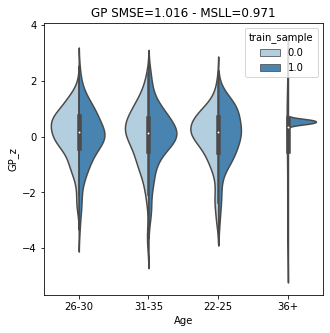

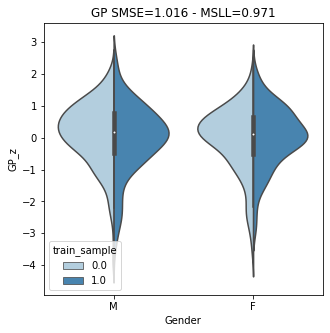

In [59]:
m.plot_z(confound='Age')
m.plot_z(confound='Gender')

In [60]:
results = m.data

In [62]:
res = results[results['train_sample'] != 1]

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = res['GP_residuals'].to_numpy()
y = res[col].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train.reshape(-1,1),y_train)
pred = svr.predict(X_test.reshape(-1,1))

(380,)
(188,)
(380,)
(188,)


<AxesSubplot:>

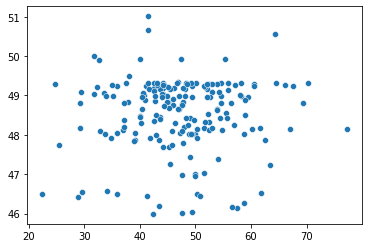

In [100]:
sns.scatterplot(x = y_test, y = pred)